# SGNN Tutorial: Stochastic SIR/SEIR/SEAIR → Observation Model → One-Pass Training → Eval

We will:

1) Implement **stochastic SIR, SEIR, SEAIR** simulators. Each day we compute expected transitions, then sample integer counts to inject process noise.  
2) Generate a synthetic training set. Synthetic pretraining avoids overfitting by generating more data instead of looping epochs.  
3) Apply an **observation model** with under-reporting, delays, and overdispersion. SGNNs must learn both mechanistic structure and become robust to real-world data effects.  
4) Define and train a small forecaster once.  
5) Evaluate on held-out synthetic validation.

In [15]:
# ==== Setup ====
import math, random, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def negbinom(mu, alpha):
    """
    Negative binomial with mean mu and dispersion alpha>0.
    Var = mu + alpha*mu^2.  Param: r=1/alpha, p=r/(r+mu).
    """
    mu = max(float(mu), 0.0)
    if mu == 0:
        return 0
    r = 1.0 / max(alpha, 1e-8)
    p = r / (r + mu)
    return np.random.negative_binomial(r, p)


## 1) Stochastic simulators: SIR, SEIR, SEAIR

In real-world outbreaks, epidemic processes are **stochastic** — the exact number of people infected, recovering, or transitioning between compartments on any given day is subject to chance.  
To mimic this, we take the classic compartmental models and make them **discrete-time and stochastic**:

1. **Day-by-day simulation:**  
   We advance in daily steps rather than solving continuous-time ODEs. This mirrors the cadence of real reporting systems (daily case counts).

2. **Expected flow calculation:**  
   For each possible transition (e.g., S → I, I → R), we calculate the *expected* number of individuals who make that transition on that day.

3. **Random sampling:**  
   Instead of moving exactly the expected number of people, we draw a random integer from a **Poisson distribution** with that expected value as the mean.  
   - This captures natural variability in contact patterns and disease transmission.
   - We clip draws to avoid moving more people than available in the source compartment.

4. **Why multiple mechanisms?**  
   Training only on SIR (Susceptible → Infectious → Recovered) risks **model mismatch** when reality contains other processes, such as:
   - **SEIR:** Adds an *Exposed* (latent) stage to capture incubation periods before becoming infectious.
   - **SEAIR:** Adds both *Exposed* and *Asymptomatic Infectious* compartments to capture the fact that some infected individuals never develop symptoms but still transmit.

   By mixing simulations from SIR, SEIR, and SEAIR during training, the model learns from a richer distribution of epidemic trajectories. This diversity:
   - Prevents overfitting to a single simplified model structure.
   - Improves robustness when applied to real-world epidemics with unknown or mixed dynamics.
   - Reflects the SGNN philosophy: **cover the space of plausible mechanistic processes** rather than trusting a single “true” simulator.

5. **Output from each simulation:**  
   - **Compartment counts over time** (S, E, A, I, R as applicable).
   - **New infections per day** (the latent incidence curve before any observation noise is added).

These latent simulations are the raw material for SGNN pretraining. In later steps, we will pass them through an observation model to create realistic training data.

In [8]:
# ==== Simulators ====
class BaseSim:
    def __init__(self, N=200_000, T=128):
        self.N, self.T = N, T

    @staticmethod
    def _poisson_clip(mean, cap):
        mean = max(0.0, float(mean))
        return min(np.random.poisson(mean), int(cap))

class SIRSim(BaseSim):
    # beta: transmission, gamma: recovery
    def sample_params(self):
        return dict(
            beta=np.random.uniform(0.15, 0.45),
            gamma=np.random.uniform(0.07, 0.25),
            I0=np.random.randint(5, 50),
        )

    def simulate(self, p):
        S, I, R = self.N - p["I0"], p["I0"], 0
        S_hist, I_hist, R_hist, new_inf_hist = [], [], [], []
        for _ in range(self.T):
            force = p["beta"] * I / self.N
            new_inf = self._poisson_clip(force * S, S)
            new_rec = self._poisson_clip(p["gamma"] * I, I)
            S -= new_inf; I += new_inf - new_rec; R += new_rec
            S_hist.append(S); I_hist.append(I); R_hist.append(R); new_inf_hist.append(new_inf)
        return {"compartments": np.stack([S_hist, I_hist, R_hist], 1),
                "new_infections": np.array(new_inf_hist)}

class SEIRSim(BaseSim):
    # beta, sigma (E->I), gamma
    def sample_params(self):
        return dict(
            beta=np.random.uniform(0.15, 0.45),
            sigma=np.random.uniform(0.15, 0.5),
            gamma=np.random.uniform(0.07, 0.25),
            E0=np.random.randint(5, 50),
        )

    def simulate(self, p):
        S, E, I, R = self.N - p["E0"], p["E0"], 0, 0
        S_hist, E_hist, I_hist, R_hist, new_inf_hist = [], [], [], [], []
        for _ in range(self.T):
            force = p["beta"] * I / self.N
            new_inf = self._poisson_clip(force * S, S)     # S->E
            new_inc = self._poisson_clip(p["sigma"] * E, E) # E->I
            new_rec = self._poisson_clip(p["gamma"] * I, I) # I->R
            S -= new_inf; E += new_inf - new_inc; I += new_inc - new_rec; R += new_rec
            S_hist.append(S); E_hist.append(E); I_hist.append(I); R_hist.append(R); new_inf_hist.append(new_inf)
        return {"compartments": np.stack([S_hist, E_hist, I_hist, R_hist], 1),
                "new_infections": np.array(new_inf_hist)}

class SEAIRSim(BaseSim):
    # beta, sigma, gamma_a, gamma_i, p_a (fraction to A)
    def sample_params(self):
        return dict(
            beta=np.random.uniform(0.15, 0.5),
            sigma=np.random.uniform(0.15, 0.5),
            gamma_a=np.random.uniform(0.07, 0.25),
            gamma_i=np.random.uniform(0.07, 0.25),
            p_a=np.random.uniform(0.2, 0.6),
            E0=np.random.randint(5, 50),
        )

    def simulate(self, p):
        S, E, A, I, R = self.N - p["E0"], p["E0"], 0, 0, 0
        S_hist, E_hist, A_hist, I_hist, R_hist, new_inf_hist = [], [], [], [], [], []
        for _ in range(self.T):
            force = p["beta"] * (A + I) / self.N
            new_inf = self._poisson_clip(force * S, S)      # S->E
            new_inc = self._poisson_clip(p["sigma"] * E, E) # E->(A or I)
            to_A = np.random.binomial(new_inc, p["p_a"])
            to_I = new_inc - to_A
            rec_a = BaseSim._poisson_clip(p["gamma_a"] * A, A)
            rec_i = BaseSim._poisson_clip(p["gamma_i"] * I, I)
            S -= new_inf; E += new_inf - new_inc; A += to_A - rec_a; I += to_I - rec_i; R += rec_a + rec_i
            S_hist.append(S); E_hist.append(E); A_hist.append(A); I_hist.append(I); R_hist.append(R); new_inf_hist.append(new_inf)
        return {"compartments": np.stack([S_hist, E_hist, A_hist, I_hist, R_hist], 1),
                "new_infections": np.array(new_inf_hist)}


## 2) Generate synthetic training/validation once

We generate enough independent trajectories to do **one pass** through training. With synthetic pretraining you avoid overfitting by **making more data**, not by looping epochs.

In [80]:
# ==== Data generation (latent) ====
N_POP, T = 200_000, 128
N_TRAIN, N_VAL = 99000, 1000  # one window per trajectory

sims = [SIRSim(N=N_POP, T=T), SEIRSim(N=N_POP, T=T), SEAIRSim(N=N_POP, T=T)]

def gen_latent(n):
    out = []
    for _ in range(n):
        sim = random.choice(sims)
        params = sim.sample_params()
        traj = sim.simulate(params)
        out.append({"mechanism": sim.__class__.__name__,
                    "new_infections": traj["new_infections"],
                    "compartments": traj["compartments"]})
    return out

train_latent = gen_latent(N_TRAIN)
val_latent   = gen_latent(N_VAL)

## 3) Observation model: under-reporting, delays, overdispersion

Real systems report a **fraction** of infections, with **delays**, and **extra-Poisson** noise. We apply:
- Binomial thinning with reporting rate ρ  
- Convolution with a discrete delay PMF  
- Negative binomial noise for overdispersion

This is essential for SGNNs to match real surveillance data. If the mechanistic core or observation realism is missing, transfer fails.

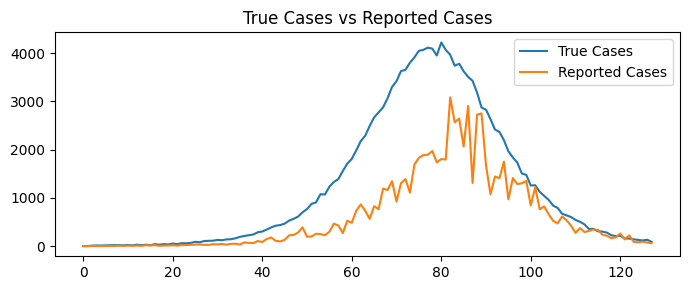

In [81]:
# ==== Observation model ====
def make_delay_pmf(max_delay=14, mean_delay=3.0):
    pmf = np.array([math.exp(-mean_delay) * mean_delay**k / math.factorial(k) for k in range(max_delay+1)])
    pmf /= pmf.sum()
    return pmf

def apply_observation_model(new_inf, rho=None, delay_pmf=None, overdisp_alpha=None):
    T = len(new_inf)
    rho = np.random.uniform(0.5, 0.8) if rho is None else rho
    delay_pmf = make_delay_pmf(14, np.random.uniform(1.5, 5.0)) if delay_pmf is None else delay_pmf
    overdisp_alpha = np.random.uniform(0.01, 0.05) if overdisp_alpha is None else overdisp_alpha

    # expected reported infections per day
    reported_expect = rho * new_inf.astype(float)

    # convolve with delay PMF, truncate to T
    L = len(delay_pmf)
    conv = np.zeros(T + L)
    for t in range(T):
        conv[t:t+L] += reported_expect[t] * delay_pmf
    conv = conv[:T]

    # NB noise
    obs = np.array([negbinom(mu, overdisp_alpha) for mu in conv])
    return obs, dict(rho=rho, delay_pmf=delay_pmf, alpha=overdisp_alpha)

def make_observed_dataset(latent_list):
    out = []
    for item in latent_list:
        y_lat = item["new_infections"]
        y_obs, obs_params = apply_observation_model(y_lat)
        out.append({"mechanism": item["mechanism"],
                    "y_latent": y_lat,
                    "y_obs": y_obs,
                    "obs_params": obs_params})
    return out

train_data = make_observed_dataset(train_latent)
val_data   = make_observed_dataset(val_latent)

# visualize one example
i = 0
plt.figure(figsize=(7,3))
plt.plot(train_data[i]["y_latent"], label="True Cases")
plt.plot(train_data[i]["y_obs"], label="Reported Cases")
plt.legend(); plt.title("True Cases vs Reported Cases"); plt.tight_layout(); plt.show()

## 4) Define and train the model

Task: given **L** days of observed cases, predict the **next H** days.  
We use a small 1-D CNN forecaster. We train for **one epoch** across the synthetic set.

In [82]:
# ==== Datasets and model ====
L, H = 64, 14  # context and horizon

class ForecastDataset(Dataset):
    def __init__(self, items, L, H):
        X, Y = [], []
        for it in items:
            y = it["y_obs"].astype(float)
            if len(y) < L + H:
                continue
            X.append(y[:L])
            Y.append(y[L:L+H])
        self.X = np.stack(X); self.Y = np.stack(Y)

    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        x = torch.tensor(self.X[i], dtype=torch.float32).unsqueeze(0)  # [1,L]
        y = torch.tensor(self.Y[i], dtype=torch.float32)               # [H]
        return x, y

train_ds = ForecastDataset(train_data, L, H)
val_ds   = ForecastDataset(val_data,   L, H)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False)

print(f"Train windows: {len(train_ds)} | Val windows: {len(val_ds)}")

class CNNForecast(nn.Module):
    def __init__(self, L, H, hidden=64, pdrop=0.1):
        super().__init__()
        # conv stack with a simple residual
        self.conv1 = nn.Conv1d(1, hidden, kernel_size=5, padding=2)
        self.bn1   = nn.BatchNorm1d(hidden)
        self.conv2 = nn.Conv1d(hidden, hidden, kernel_size=5, padding=2)
        self.bn2   = nn.BatchNorm1d(hidden)
        self.drop  = nn.Dropout(pdrop)

        # pooling + small MLP head
        self.pool  = nn.AdaptiveAvgPool1d(32)
        self.fc1   = nn.Linear(hidden * 32, 256)
        self.fc2   = nn.Linear(256, H)

        self.out_act = nn.Softplus()  # nonnegative counts

        # init
        for m in (self.conv1, self.conv2):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None: nn.init.zeros_(m.bias)
        nn.init.xavier_uniform_(self.fc1.weight); nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight); nn.init.zeros_(self.fc2.bias)

    def forward(self, x):           # x: [B,1,L]
        h1 = F.relu(self.bn1(self.conv1(x)))
        h1 = self.drop(h1)
        h2 = F.relu(self.bn2(self.conv2(h1)))
        h2 = self.drop(h2)
        h  = h1 + h2                 # simple residual
        h  = self.pool(h)
        h  = torch.flatten(h, 1)
        h  = F.relu(self.fc1(h))
        y  = self.fc2(h)
        return self.out_act(y)

model = CNNForecast(L, H).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-2, weight_decay=1e-4)
loss_fn = nn.MSELoss()

# ==== One-pass training ====
model.train()
for xb, yb in train_loader:
    xb, yb = xb.to(device), yb.to(device)
    opt.zero_grad()
    pred = model(xb)
    loss = loss_fn(pred, yb)
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()

Train windows: 99000 | Val windows: 1000


## 5) Evaluate on synthetic validation

We now report validation MAE and RMSE.  
In real use you would now apply the model to **real data** with similar observation characteristics.

Val MAE:  184.687
Val RMSE: 373.931


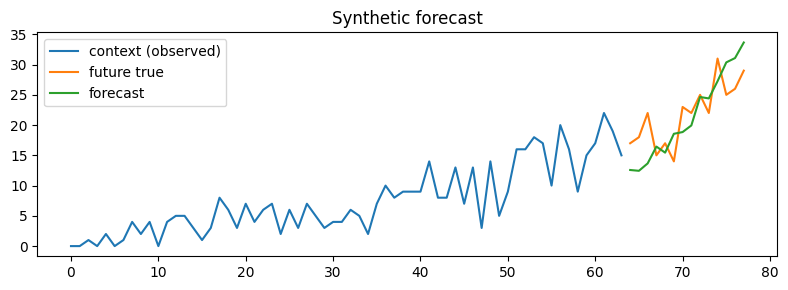

In [83]:
# ==== Evaluation ====
def mae(a, b): return float(np.mean(np.abs(a - b)))
def rmse(a, b): return float(np.sqrt(np.mean((a - b)**2)))

model.eval()
all_mae, all_rmse = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        pred = model(xb.to(device)).cpu().numpy()
        y    = yb.numpy()
        all_mae.append(mae(y, pred))
        all_rmse.append(rmse(y, pred))

print(f"Val MAE:  {np.mean(all_mae):.3f}")
print(f"Val RMSE: {np.mean(all_rmse):.3f}")

# one example forecast
xb, yb = next(iter(val_loader))
with torch.no_grad():
    pred = model(xb.to(device)).cpu().numpy()[0]
x_hist = xb[0,0].numpy(); y_true = yb[0].numpy()

plt.figure(figsize=(8,3))
plt.plot(range(len(x_hist)), x_hist, label="context (observed)")
plt.plot(range(len(x_hist), len(x_hist)+len(y_true)), y_true, label="future true")
plt.plot(range(len(x_hist), len(x_hist)+len(pred)), pred, label="forecast")
plt.legend(); plt.title("Synthetic forecast"); plt.tight_layout(); plt.show()
